In [31]:
!pip install pandas sentence-transformers transformers scikit-learn tqdm --quiet
pip install sentence-transformers transformers scikit-learn pandas


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import pandas as pd
import ast

df = pd.read_csv("Diagnoses_list.csv")  # contains Diagnoses_list column
df["Diagnoses_list"] = df["Diagnoses_list"].apply(ast.literal_eval)

icd_df = pd.read_csv("icd10_codes.csv")  # with 'code', 'description'


In [8]:
icd_df

,ICDCode,Description
0,A000,"Cholera due to Vibrio cholerae 01, biovar c..."
1,A001,"Cholera due to Vibrio cholerae 01, biovar e..."
2,A009,"Cholera, unspecified"
3,A0100,"Typhoid fever, unspecified"
4,A0101,Typhoid meningitis
...,...,...
73634,Z9981,Dependence on supplemental oxygen
73635,Z9989,Dependence on other enabling machines and de...
73636,U070,Vaping-related disorder
73637,U071,COVID-19


In [9]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

model = SentenceTransformer("all-MiniLM-L6-v2")

# Embed ICD descriptions
icd_embeddings = model.encode(icd_df["Description"].tolist(), show_progress_bar=True)


c:\Users\LENOVO\Downloads\ocd\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\LENOVO\Downloads\ocd\env\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LENOVO\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to

In [10]:
def map_diagnosis_to_icd(diagnosis):
    diag_embedding = model.encode([diagnosis])
    sims = cosine_similarity(diag_embedding, icd_embeddings)[0]
    best_idx = np.argmax(sims)
    best_score = sims[best_idx]
    
    return {
        "diagnosis": diagnosis,
        "code": icd_df.iloc[best_idx]["code"],
        "description": icd_df.iloc[best_idx]["description"],
        "score": best_score
    }


In [20]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

# You can swap in phi-3 or mistral here
llm_model = "microsoft/DialoGPT-medium"
tokenizer = AutoTokenizer.from_pretrained(llm_model)
model = AutoModelForCausalLM.from_pretrained(llm_model)

gen = pipeline("text-generation", model=model, tokenizer=tokenizer)

def generate_explanation(diagnosis, code, description):
    prompt = f"""You are a medical coder. Write a short justification for why the ICD-10 code matches the diagnosis.

Diagnosis: {diagnosis}
ICD-10 Code: {code}
ICD-10 Description: {description}

Explanation:"""
    output = gen(prompt, max_new_tokens=60, do_sample=False)[0]["generated_text"]
    return output.split("Explanation:")[-1].strip()


Device set to use cpu


In [17]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

llm_model = "microsoft/DialoGPT-medium"
tokenizer = AutoTokenizer.from_pretrained(llm_model)
# Remove both device_map and torch_dtype
model = AutoModelForCausalLM.from_pretrained(llm_model)

gen = pipeline("text-generation", model=model, tokenizer=tokenizer)

def generate_explanation(diagnosis, code, description):
    prompt = f"""You are a medical coder. Write a short justification for why the ICD-10 code matches the diagnosis.

Diagnosis: {diagnosis}
ICD-10 Code: {code}
ICD-10 Description: {description}

Explanation:"""
    output = gen(prompt, max_new_tokens=60, do_sample=False)[0]["generated_text"]
    return output.split("Explanation:")[-1].strip()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Device set to use cpu


In [29]:
def map_diagnosis_to_icd(diagnosis):
    diag_embedding = embedding_model.encode([diagnosis])
    sims = cosine_similarity(diag_embedding, icd_embeddings)[0]
    best_idx = np.argmax(sims)
    best_score = sims[best_idx]

    return {
        "diagnosis": diagnosis,
        "ICDCode": icd_df.iloc[best_idx]["ICDCode"],
        "Description": icd_df.iloc[best_idx]["Description"],
        "score": best_score
    }


In [30]:
results = []

for _, row in df.iterrows():
    for diag in row["Diagnoses_list"]:
        mapped = map_diagnosis_to_icd(diag)
        explanation = generate_explanation(mapped["diagnosis"], mapped["code"], mapped["Description"])
        
        results.append({
            "Original Diagnosis": mapped["diagnosis"],
            "ICD-10 Code": mapped["ICDCode"],
            "ICD-10 Description": mapped["Description"],
            "Explanation": explanation,
            "Similarity Score": round(mapped["score"], 3)
        })

output_df = pd.DataFrame(results)


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:5

KeyboardInterrupt: 

In [22]:
# Load embedding model
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Later load LLM (don't overwrite model)
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
llm_name = "microsoft/phi-2"

tokenizer = AutoTokenizer.from_pretrained(llm_name)
gen_model = AutoModelForCausalLM.from_pretrained(llm_name)
pipe = pipeline("text-generation", model=gen_model, tokenizer=tokenizer)


c:\Users\LENOVO\Downloads\ocd\env\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LENOVO\.cache\huggingface\hub\models--microsoft--phi-2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]Xet Storage is enabled for this repo, but the 'hf_xet' package 

In [33]:
# Let's now reconstruct the full solution using the exact format of your inputs:
# 1. Input diagnosis CSV (Diagnoses_list.csv with a column "Diagnoses_list" where each cell is a stringified list)
# 2. ICD-10 code descriptions CSV (icd10_codes.csv with columns: ICDCode, Description)

import pandas as pd
import numpy as np
import ast
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# === Step 1: Load the datasets ===
diagnosis_df = pd.read_csv("Diagnoses_list.csv")  # Column: Diagnoses_list (as stringified list)
icd_df = pd.read_csv("icd10_codes.csv")  # Columns: ICDCode, Description

# Clean column names
icd_df.columns = [col.strip() for col in icd_df.columns]
icd_df['Description'] = icd_df['Description'].str.strip()

# Convert stringified list to actual Python list
diagnosis_df["Diagnoses_list"] = diagnosis_df["Diagnoses_list"].apply(ast.literal_eval)

# === Step 2: Load the sentence embedding model ===
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Pre-compute ICD description embeddings
icd_descriptions = icd_df["Description"].tolist()
icd_embeddings = embedding_model.encode(icd_descriptions, convert_to_tensor=False)

# === Step 3: Function to map diagnosis to ICD code ===
def map_diagnosis_to_icd(diagnosis):
    diag_embedding = embedding_model.encode([diagnosis])
    sims = cosine_similarity(diag_embedding, icd_embeddings)[0]
    best_idx = np.argmax(sims)
    best_score = sims[best_idx]
    return {
        "diagnosis": diagnosis,
        "code": icd_df.iloc[best_idx]["ICDCode"],
        "description": icd_df.iloc[best_idx]["Description"],
        "score": best_score
    }

# === Step 4: Load a small open-source LLM for explanations ===
llm_model_name = "microsoft/phi-2"  # Small and free model
tokenizer = AutoTokenizer.from_pretrained(llm_model_name)
gen_model = AutoModelForCausalLM.from_pretrained(llm_model_name)
pipe = pipeline("text-generation", model=gen_model, tokenizer=tokenizer)

# === Step 5: Generate Explanation ===
def generate_explanation(diagnosis, code, description):
    prompt = f"""You are a medical expert. Explain why this ICD-10 code is assigned.
Diagnosis: {diagnosis}
ICD-10 Code: {code}
ICD-10 Description: {description}

Explanation:"""
    result = pipe(prompt, max_new_tokens=80, do_sample=True, temperature=0.7)[0]['generated_text']
    return result.split("Explanation:")[-1].strip()

# === Step 6: Process all rows ===
results = []

for i, row in enumerate(diagnosis_df.iterrows()):
    print(i)
    if i >= 3:  # Only process first 3 rows
        break
    _, row_data = row
    for diag in row_data["Diagnoses_list"]:
        mapped = map_diagnosis_to_icd(diag)
        explanation = generate_explanation(mapped["diagnosis"], mapped["code"], mapped["description"])
        
        results.append({
            "Original Diagnosis": mapped["diagnosis"],
            "ICD-10 Code": mapped["code"],
            "ICD-10 Description": mapped["description"],
            "Explanation": explanation,
            "Similarity Score": round(mapped["score"], 3)
        })

# === Step 7: Save output to CSV ===
output_df = pd.DataFrame(results)
output_df.to_csv("mapped_icd10_output.csv", index=False)
output_df.head(10)  # Preview first 10 rows



Loading checkpoint shards: 100%|██████████| 2/2 [00:33<00:00, 16.88s/it]
Device set to use cpu


0


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

3


,Original Diagnosis,ICD-10 Code,ICD-10 Description,Explanation,Similarity Score
0,Diabetes mellitus without mention of complicat...,E1169,Type 2 diabetes mellitus with other specified ...,Type 2 diabetes mellitus is a chronic metaboli...,0.880
1,Pure hypercholesterolemia,E7800,"Pure hypercholesterolemia, unspecified","In this case, the patient has been diagnosed w...",0.946
2,Unspecified acquired hypothyroidism,E039,"Hypothyroidism, unspecified",This ICD-10 code is assigned because the patie...,0.938
3,Tobacco use disorder,Z720,Tobacco use,This ICD-10 code is assigned because it indica...,0.802
4,Personal history of malignant melanoma of skin,Z85820,Personal history of malignant melanoma of skin,This ICD-10 code (Z85820) is assigned to indic...,1.000
5,"Hypotension, unspecified",I959,"Hypotension, unspecified",- Hypotension refers to low blood pressure.\n-...,1.000
6,Acute appendicitis with generalized peritonitis,K3520,Acute appendicitis with generalized peritoniti...,This code represents a medical diagnosis of ac...,0.967
7,Long-term (current) use of aspirin,Z7982,Long term (current) use of aspirin,The ICD-10 code Z7982 is assigned to indicate ...,0.996
8,"Acquired absence of organ, genital organs",Z9079,Acquired absence of other genital organ(s),"In this case, the absence of a genital organ i...",0.938
9,Unspecified essential hypertension,I10,Essential (primary) hypertension,The ICD-10 code I10 is assigned to this diagno...,0.889


In [38]:
diagnosis_df

,Diagnoses_list
0,[Diabetes mellitus without mention of complica...
1,"[Long-term (current) use of anticoagulants, Ob..."
2,"[Acute respiratory failure, Hypopotassemia, Pe..."
3,[Antineoplastic and immunosuppressive drugs ca...
4,[Personal history of malignant neoplasm of ton...
...,...
95,"[Grand mal status, Unspecified fall, Backache,..."
96,"[Long-term (current) use of anticoagulants, To..."
97,"[Atrial flutter, Chronic systolic (congestive)..."
98,[Gastro-esophageal reflux disease without esop...


In [40]:
# Install these once:
# pip install pandas sentence-transformers scikit-learn tqdm

import pandas as pd
import ast
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# === Step 1: Load Data ===
# Diagnoses_list.csv has a column "Diagnoses_list" with Python‑list strings
# icd10_codes.csv has columns "ICDCode", "Description"
diagnosis_df = pd.read_csv("Diagnoses_list.csv")
icd_df       = pd.read_csv("icd10_codes.csv")

# Parse the stringified lists
diagnosis_df["Diagnoses_list"] = diagnosis_df["Diagnoses_list"].apply(ast.literal_eval)

# === Step 2: Embed ICD Descriptions ===
embedder      = SentenceTransformer("all-MiniLM-L6-v2")
icd_texts     = icd_df["Description"].tolist()
icd_embeddings = embedder.encode(icd_texts, show_progress_bar=True)

# === Step 3: Helper to Map One Diagnosis ===
def map_one(diag_text):
    # get embedding + cosine similarities
    emb = embedder.encode([diag_text])
    sims = cosine_similarity(emb, icd_embeddings)[0]
    idx = np.argmax(sims)
    return {
        "code": icd_df.at[idx, "ICDCode"],
        "description": icd_df.at[idx, "Description"],
        "score": round(float(sims[idx]), 3)
    }

# === Step 4: Template Explanation (SUPER FAST) ===
def explain(diag, code, desc):
    return (
        f"'{diag}' → {code} because it semantically matches: "
        f"\"{desc}\" (sim={round(code_score_lookup[(diag,code)],3)})."
    )

# (Optional) If you want explanations to reference the actual score
# you can build a small cache while mapping:
code_score_lookup = {}

# === Step 5: Process Rows with Progress Bar ===
MAX_ROWS = 5
results = []

for _, row in tqdm(diagnosis_df.head(MAX_ROWS).iterrows(), total=MAX_ROWS, desc="Patients"):
    codes, descs, expls = [], [], []
    for diag in row["Diagnoses_list"]:
        m = map_one(diag)
        codes.append(m["code"])
        descs.append(m["description"])
        # store score for use in explanation
        code_score_lookup[(diag, m["code"])] = m["score"]
        expls.append(explain(diag, m["code"], m["description"]))
    # append new columns per patient
    row["Mapped_Codes"]        = codes
    row["Mapped_Descriptions"] = descs
    row["Explanations"]        = expls
    results.append(row)

# === Step 6: Assemble and Save ===
out_df = pd.DataFrame(results).reset_index(drop=True)
out_df.to_csv("mapped_icd10_per_patient.csv", index=False)

print("Sample output:")
print(out_df[[
    "Diagnoses_list","Mapped_Codes","Mapped_Descriptions","Explanations"
]].head())


Patients: 100%|██████████| 5/5 [00:12<00:00,  2.60s/it]

Sample output:
                                      Diagnoses_list  \
0  [Diabetes mellitus without mention of complica...   
1  [Long-term (current) use of anticoagulants, Ob...   
2  [Acute respiratory failure, Hypopotassemia, Pe...   
3  [Antineoplastic and immunosuppressive drugs ca...   
4  [Personal history of malignant neoplasm of ton...   

                                        Mapped_Codes  \
0  [E1169, E7800, E039, Z720, Z85820, I959, K3520...   
1  [Z7901, E669, S72399A, S2243XA, V29498D, Z720,...   
2  [J95821, E8351, I739, I872, I3489, Z90710, M54...   
3  [T451X5S, L89892, E7849, R634, K5900, B9620, C...   
4  [Z85810, J95821, D688, J45909, R0682, E7849, N...   

                                 Mapped_Descriptions  \
0  [  Type 2 diabetes mellitus with other specifi...   
1  [  Long term (current) use of anticoagulants, ...   
2  [ Acute postprocedural respiratory failure,   ...   
3  [Adverse effect of antineoplastic and immunosu...   
4  [ Personal history of malign

In [63]:
# Install once if needed:
# pip install pandas sentence-transformers scikit-learn tqdm transformers

import pandas as pd
import ast
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModelForCausalLM, TextGenerationPipeline

# === Step 1: Load Data ===
diag_df = pd.read_csv("Diagnoses_list.csv")
icd_df  = pd.read_csv("icd10_codes.csv")
diag_df["Diagnoses_list"] = diag_df["Diagnoses_list"].apply(ast.literal_eval)

# === Step 2: Embed ICD Descriptions ===
embedder       = SentenceTransformer("all-MiniLM-L6-v2")
icd_texts      = icd_df["Description"].tolist()
icd_embeddings = embedder.encode(icd_texts, show_progress_bar=True)



# === Step 5: Batch & Cache Explanations ===

# def generate_explanations_batch(prompts):
#     """Take a list of prompt strings, return list of outputs"""
#     outputs = llm(prompts, pad_token_id=tokenizer.eos_token_id)
#     return [out["generated_text"].split("Explanation:")[-1].strip() for out in outputs]

# === Step 6: Process Patients ===
#    MAX_ROWS = 5
# results  = []

# for _, row in tqdm(diag_df.head(MAX_ROWS).iterrows(), total=MAX_ROWS, desc="Patients"):
#     codes, descs, scores = [], [], []
#     # First, map all diagnoses
#     mapped = [map_one(d) for d in row["Diagnoses_list"]]
#     # Build prompts for those not yet in cache
#     prompts = []
#     keys    = []
#     for (d, (code, desc, score)) in zip(row["Diagnoses_list"], mapped):
#         key = (d, code)
#         if key not in explanation_cache:
#             prompt = (
#                 f"You are a medical coder.\n"
#                 f"Diagnosis: {d}\n"
#                 f"ICD-10 Code: {code}\n"
#                 f"Description: {desc}\n\n"
#                 f"Explanation:"
#             )
#             prompts.append(prompt)
#             keys.append(key)
#     # Generate in one batch
#     if prompts:
#         exps = generate_explanations_batch(prompts)
#         for k, e in zip(keys, exps):
#             explanation_cache[k] = e
#     # Collect per-patient lists
#     for d, (code, desc, score) in zip(row["Diagnoses_list"], mapped):
#         codes.append(code)
#         descs.append(desc)
#         scores.append(round(score, 3))
#     # Save results
#     results.append({
#      "Diagnoses_list":        row["Diagnoses_list"],
#         "Mapped_Codes":          codes,
#         "Mapped_Descriptions":   descs,
#         "Similarity_Scores":     scores,
#         "Explanations":          [explanation_cache[(d,c)] for d,c in zip(row["Diagnoses_list"], codes)]
#     })

# # === Step 7: Save Output ===
# out_df = pd.DataFrame(results)
# out_df.to_csv("mapped_icd10_with_llm.csv", index=False)

# # Preview
# print(out_df.head())


Batches: 100%|██████████| 2302/2302 [03:52<00:00,  9.88it/s]
c:\Users\LENOVO\Downloads\ocd\env\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LENOVO\.cache\huggingface\hub\models--microsoft--BioGPT-Large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


ImportError: 
 requires the protobuf library but it was not found in your environment. Check out the instructions on the
installation page of its repo: https://github.com/protocolbuffers/protobuf/tree/master/python#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.


In [67]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load the medical model
model = AutoModelForCausalLM.from_pretrained(
    "bkholyday/Qwen2.5-0.5B-Instruct-medicalLLM-HuatuoGPT-o1-sft", 
    trust_remote_code=True
)
tokenizer = AutoTokenizer.from_pretrained(
    "bkholyday/Qwen2.5-0.5B-Instruct-medicalLLM-HuatuoGPT-o1-sft", 
    trust_remote_code=True
)

def generate_explanation(diagnosis, code, description):
    """Generate medical explanation using the medical LLM"""
    
    # Create a medical-focused prompt
    question = f"Why does ICD-10 code {code} match the diagnosis '{diagnosis}'? The ICD-10 description is: {description}"
    
    # Prepare input using chat template
    messages = [{"role": "user", "content": question}]
    input_text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    
    # Generate response
    input_ids = tokenizer.encode(input_text, return_tensors="pt")
    output_ids = model.generate(
        input_ids, 
        max_new_tokens=150,
        do_sample=True,
        temperature=0.7,
        pad_token_id=tokenizer.eos_token_id
    )
    
    response = tokenizer.decode(output_ids[0][input_ids.shape[1]:], skip_special_tokens=True)
    return response.strip()

# Use it in your mapping function
def map_one(d):
    emb = embedder.encode([d])
    sims = cosine_similarity(emb, icd_embeddings)[0]
    idx = np.argmax(sims)
    code = icd_df.at[idx, "ICDCode"]
    description = icd_df.at[idx, "Description"]
    similarity = float(sims[idx])
    
    # Generate explanation using the medical LLM
    explanation = generate_explanation(d, code, description)
    
    return code, description, similarity, explanation

c:\Users\LENOVO\Downloads\ocd\env\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LENOVO\.cache\huggingface\hub\models--bkholyday--Qwen2.5-0.5B-Instruct-medicalLLM-HuatuoGPT-o1-sft. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [66]:
# === Step 3: Mapping Helper ===
def map_one(d):
    emb  = embedder.encode([d])
    sims = cosine_similarity(emb, icd_embeddings)[0]
    idx  = np.argmax(sims)
    return icd_df.at[idx, "ICDCode"], icd_df.at[idx, "Description"], float(sims[idx])

# === Step 4: Prepare Small LLM ===
# distilgpt2 is small (~82M), quick on CPU
tokenizer = AutoTokenizer.from_pretrained("microsoft/BioGPT-Larg")
model     = AutoModelForCausalLM.from_pretrained("microsoft/BioGPT-Larg")
llm       = TextGenerationPipeline(model, tokenizer,
                                   device=-1,      # CPU
                                   framework="pt",
                                   max_length=100,
                                   do_sample=False)

OSError: microsoft/BioGPT-Larg is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [57]:
explanation_cache = {}
def generate_explanation(diagnosis, code, description):
    prompt = f"""Explain why ICD-10 code {code} matches diagnosis "{diagnosis}":"""
    
    print(f"Generating explanation for: {diagnosis} -> {code}")  # Debug
    
    try:
        output = gen(prompt, max_new_tokens=100, do_sample=True, temperature=0.7)[0]["generated_text"]
        explanation = output.split(":")[-1].strip()
        
        print(f"Raw output: {output}")  # Debug
        print(f"Explanation: {explanation}")  # Debug
        
        return explanation if explanation else f"Code {code} matches '{diagnosis}'"
    except Exception as e:
        print(f"Error for {diagnosis}: {e}")
        return f"Code {code} matches '{diagnosis}'"

In [68]:
MAX_ROWS = 5
results  = []

for _, row in tqdm(diag_df.head(MAX_ROWS).iterrows(), total=MAX_ROWS, desc="Patients"):
    codes, descs, scores = [], [], []
    # First, map all diagnoses
    mapped = [map_one(d) for d in row["Diagnoses_list"]]
    # Build prompts for those not yet in cache
    prompts = []
    keys    = []
    for (d, (code, desc, score)) in zip(row["Diagnoses_list"], mapped):
        key = (d, code)
        if key not in explanation_cache:
            prompt = (
                f"You are a medical coder.\n"
                f"Diagnosis: {d}\n"
                f"ICD-10 Code: {code}\n"
                f"Description: {desc}\n\n"
                f"Explanation:"
            )
            prompts.append(prompt)
            keys.append(key)
    # Generate in one batch
    if prompts:
        exps = generate_explanations_batch(prompts)
        for k, e in zip(keys, exps):
            explanation_cache[k] = e
    # Collect per-patient lists
    for d, (code, desc, score) in zip(row["Diagnoses_list"], mapped):
        codes.append(code)
        descs.append(desc)
        scores.append(round(score, 3))
    # Save results
    results.append({
        "Diagnoses_list":        row["Diagnoses_list"],
        "Mapped_Codes":          codes,
        "Mapped_Descriptions":   descs,
        "Similarity_Scores":     scores,
        "Explanations":          [explanation_cache[(d,c)] for d,c in zip(row["Diagnoses_list"], codes)]
    })

# === Step 7: Save Output ===
out_df = pd.DataFrame(results)
out_df.to_csv("mapped_icd10_with_llm.csv", index=False)

# Preview
print(out_df.head())

Patients:   0%|          | 0/5 [03:50<?, ?it/s]


ValueError: too many values to unpack (expected 3)

In [75]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

# === Load TinyClinicalBERT for Text Generation ===
model_name = "nlpie/tiny-clinicalbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Add special tokens for generation
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def generate_medical_explanation(diagnosis, code, description):
    """Generate actual medical explanation using the model"""
    
    # Create a detailed medical prompt
    prompt = f"""As a medical coding specialist, explain why ICD-10 code {code} matches the diagnosis "{diagnosis}".

Diagnosis: {diagnosis}
ICD-10 Code: {code}
ICD-10 Description: {description}

Medical reasoning:"""
    
    try:
        # Tokenize the prompt
        inputs = tokenizer(
            prompt, 
            return_tensors="pt", 
            max_length=200, 
            truncation=True, 
            padding=True
        )
        
        # Generate response using the model
        with torch.no_grad():
            outputs = model.generate(
                inputs["input_ids"],
                max_new_tokens=100,
                do_sample=True,
                temperature=0.7,
                top_p=0.9,
                pad_token_id=tokenizer.eos_token_id,
                eos_token_id=tokenizer.eos_token_id
            )
        
        # Decode the generated text
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Extract only the generated part (after the prompt)
        explanation = generated_text.replace(prompt, "").strip()
        
        # If explanation is too short, try a different approach
        if len(explanation) < 20:
            return generate_fallback_explanation(diagnosis, code, description)
        
        return explanation
        
    except Exception as e:
        print(f"Generation error: {e}")
        return generate_fallback_explanation(diagnosis, code, description)

def generate_fallback_explanation(diagnosis, code, description):
    """Fallback method using different prompting strategy"""
    
    # Try a simpler prompt
    simple_prompt = f"Explain medical code {code} for {diagnosis}:"
    
    try:
        inputs = tokenizer(simple_prompt, return_tensors="pt", max_length=100, truncation=True)
        
        with torch.no_grad():
            outputs = model.generate(
                inputs["input_ids"],
                max_new_tokens=80,
                do_sample=True,
                temperature=0.8,
                pad_token_id=tokenizer.eos_token_id
            )
        
        explanation = tokenizer.decode(outputs[0], skip_special_tokens=True)
        return explanation.replace(simple_prompt, "").strip()
        
    except:
        return f"ICD-10 code {code} is clinically appropriate for {diagnosis} based on semantic matching with '{description}'"
# === Step 3: Enhanced Mapping Function with TinyClinicalBERT ===
def map_diagnosis_to_icd_enhanced(diagnosis):
    """Map diagnosis to ICD-10 code with medical explanation"""
    
    # Get embedding for the diagnosis
    diag_embedding = embedder.encode([diagnosis])
    sims = cosine_similarity(diag_embedding, icd_embeddings)[0]
    best_idx = np.argmax(sims)
    best_score = sims[best_idx]
    
    # Get ICD details
    code = icd_df.iloc[best_idx]["ICDCode"]
    description = icd_df.iloc[best_idx]["Description"]
    
    # Generate medical explanation using TinyClinicalBERT
    explanation = generate_medical_explanation(diagnosis, code, description)
    
    return {
        "diagnosis": diagnosis,
        "code": code,
        "description": description,
        "score": best_score,
        "explanation": explanation
    }

# === Step 4: Process All Diagnoses with Enhanced Explanations ===
results = []

for i, row in df.iterrows():
    if i == 3:break
    for diag in row["Diagnoses_list"]:
        # Map diagnosis with enhanced medical explanation
        mapped = map_diagnosis_to_icd_enhanced(diag)
        
        results.append({
            "Original Diagnosis": mapped["diagnosis"],
            "ICD-10 Code": mapped["code"],
            "ICD-10 Description": mapped["description"],
            "Similarity Score": round(mapped["score"], 3),
            "Medical Explanation": mapped["explanation"],
            "Confidence Level": "High" if mapped["score"] > 0.9 else "Medium" if mapped["score"] > 0.8 else "Low"
        })

# Create output DataFrame
output_df = pd.DataFrame(results)

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`


In [77]:
output_df

,Original Diagnosis,ICD-10 Code,ICD-10 Description,Similarity Score,Medical Explanation,Confidence Level
0,"Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled",E1169,Type 2 diabetes mellitus with other specified complication,0.880,"As a medical coding specialist, explain why ICD - 10 code E1169 matches the diagnosis "" Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled "". Diagnosis : Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled ICD - 10 Code : E1169 ICD - 10 Description : Type 2 diabetes mellitus with other specified complication Medical reasoning :....................................................................................................",Medium
1,Pure hypercholesterolemia,E7800,"Pure hypercholesterolemia, unspecified",0.946,"As a medical coding specialist, explain why ICD - 10 code E7800 matches the diagnosis "" Pure hypercholesterolemia "". Diagnosis : Pure hypercholesterolemia ICD - 10 Code : E7800 ICD - 10 Description : Pure hypercholesterolemia, unspecified Medical reasoning :....................................................................................................",High
2,Unspecified acquired hypothyroidism,E039,"Hypothyroidism, unspecified",0.938,"As a medical coding specialist, explain why ICD - 10 code E039 matches the diagnosis "" Unspecified acquired hypothyroidism "". Diagnosis : Unspecified acquired hypothyroidism ICD - 10 Code : E039 ICD - 10 Description : Hypothyroidism, unspecified Medical reasoning :....................................................................................................",High
3,Tobacco use disorder,Z720,Tobacco use,0.802,"As a medical coding specialist, explain why ICD - 10 code Z720 matches the diagnosis "" Tobacco use disorder "". Diagnosis : Tobacco use disorder ICD - 10 Code : Z720 ICD - 10 Description : Tobacco use Medical reasoning :....................................................................................................",Medium
4,Personal history of malignant melanoma of skin,Z85820,Personal history of malignant melanoma of skin,1.000,"As a medical coding specialist, explain why ICD - 10 code Z85820 matches the diagnosis "" Personal history of malignant melanoma of skin "". Diagnosis : Personal history of malignant melanoma of skin ICD - 10 Code : Z85820 ICD - 10 Description : Personal history of malignant melanoma of skin Medical reasoning :....................................................................................................",High
...,...,...,...,...,...,...
57,"Congestive heart failure, unspecified",I5020,Unspecified systolic (congestive) heart failure,0.872,"As a medical coding specialist, explain why ICD - 10 code I5020 matches the diagnosis "" Congestive heart failure, unspecified "". Diagnosis : Congestive heart failure, unspecified ICD - 10 Code : I5020 ICD - 10 Description : Unspecified systolic ( congestive ) heart failure Medical reasoning :....................................................................................................",Medium
58,Esophageal reflux,T85591D,"Other mechanical complication of esophageal anti-reflux device, subsequent encounter",0.867,"As a medical coding specialist, explain why ICD - 10 code T85591D matches the diagnosis "" Esophageal reflux "". Diagnosis : Esophageal reflux ICD - 10 Code : T85591D ICD - 10 Description : Other mechanical complication of esophageal anti - reflux device, subsequent encounter Medical reasoning :....................................................................................................",Medium
59,"Other dependence on machines, supplemental oxygen",Z9981,Dependence on supplemental oxygen,0.724,"As a medical coding specialist, explain why ICD - 10 code Z9981 matches the diagnosis "" Other dependence on machines, supplemental oxygen "". Diagnosis : Other dependence on machines, s

In [76]:
# Display full medical explanations without truncation
pd.set_option('display.max_colwidth', None)
output_df['Medical Explanation'].head(5)

0    As a medical coding specialist, explain why ICD - 10 code E1169 matches the diagnosis " Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled ". Diagnosis : Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled ICD - 10 Code : E1169 ICD - 10 Description : Type 2 diabetes mellitus with other specified complication Medical reasoning :....................................................................................................
1                                                                                                                                                                                          As a medical coding specialist, explain why ICD - 10 code E7800 matches the diagnosis " Pure hypercholesterolemia ". Diagnosis : Pure hypercholesterolemia ICD - 10 Code : E7800 ICD - 10 Description : Pure hypercholesterolemia, unspecified Medical reasoning :.........

In [134]:
df = pd.read_csv('rag_output.csv')
df
# df['RAG Explanation'].unique()

,Row_ID,Original Diagnosis,ICD-10 Code,ICD-10 Description,Similarity Score,RAG Explanation,Model Used
0,0,"Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled",E1169,Type 2 diabetes mellitus with other specified complication,0.880,"The answer should be concise and to the point.\nThe ICD-10 code E1169 correctly matches the clinical presentation of Type 2 Diabetes Mellitus (T2DM) with an additional complication, which is ""other specified."" This indicates that the patient has been diagnosed with T2DM but also has another condition that requires further evaluation or management. It suggests that the patient may have complications related to their diabetes, such as cardiovascular disease, kidney failure, or nerve damage. Therefore, this code provides a comprehensive understanding of the patient's condition, including both the primary diagnosis and any",Local LLM
1,0,Pure hypercholesterolemia,E7800,"Pure hypercholesterolemia, unspecified",0.946,"The answer should be based on clinical reasoning rather than general knowledge of ICD‑10 codes.\nThe patient's condition is characterized by an elevated level of cholesterol in their blood, which can lead to various cardiovascular issues such as heart disease and stroke. This condition is typically managed with medication and lifestyle changes, but it may also require further evaluation if there are concerns about the severity or progression of the condition. Given these factors, the most appropriate ICD‑10 code for this patient would be E7800, specifically E7800.2, which indicates that the patient has",Local LLM
2,0,Unspecified acquired hypothyroidism,E039,"Hypothyroidism, unspecified",0.938,"The answer should be concise yet comprehensive.\nThe ICD-10 code E039 for ""Hypothyroidism, unspecified"" is correct because it accurately reflects the clinical presentation of unexplained hypothyroidism, which is consistent with the assignment of E039. This code clearly indicates that the condition is not due to an underlying thyroid disorder but rather an unrecognized cause leading to hypothyroidism. It also provides a clear indication of the absence of any known causes of hypothyroidism in the patient's history, making it suitable for the specific diagnostic criteria provided by the",Local LLM
3,0,Tobacco use disorder,Z720,Tobacco use,0.802,"The answer should be based on clinical reasoning rather than general knowledge of ICD‑10 codes.\nThe ICD-10 code Z720 — ""Tobacco use"" is correct for the diagnosis of tobacco use disorder because it specifically identifies the condition as a result of smoking, which aligns with the symptoms described in the patient's history. This code accurately reflects the complexity and severity of the disorder, indicating that the patient has developed a habit of using tobacco products to cope with stress or other negative emotions. Additionally, the code categorizes the disorder under the broader category of substance abuse",Local LLM
4,0,Personal history of malignant melanoma of skin,Z85820,Personal history of malignant melanoma of skin,1.000,"The answer should be concise and to the point.\nThe ICD-10 code ""Z85820"" correctly matches the personal history of malignant melanoma of skin because it specifically codes for a condition that involves the development of cancerous cells in the skin, which aligns with the clinical presentation described in the diagnosis. This code accurately reflects the patient's condition without any discrepancies or additional information needed to complete the coding process. Therefore, it is the most appropriate match among all available options. \n\nExplanation:\nThis ICD-10 code is the most appropriate match because it precisely describes",Local LLM
5,0,"Hypotension, unspecified",I959,"Hypotension, unspecified",1.000,"The answer should be concise yet comprehensive.\nThe ICD-10 code ""I959"" for Hypotension, Unspecified is correct because it accurately describes a condition where there

In [136]:
df['RAG Explanation'].unique()

array(['The answer should be concise and to the point.\nThe ICD-10 code E1169 correctly matches the clinical presentation of Type 2 Diabetes Mellitus (T2DM) with an additional complication, which is "other specified." This indicates that the patient has been diagnosed with T2DM but also has another condition that requires further evaluation or management. It suggests that the patient may have complications related to their diabetes, such as cardiovascular disease, kidney failure, or nerve damage. Therefore, this code provides a comprehensive understanding of the patient\'s condition, including both the primary diagnosis and any',
       "The answer should be based on clinical reasoning rather than general knowledge of ICD‑10 codes.\nThe patient's condition is characterized by an elevated level of cholesterol in their blood, which can lead to various cardiovascular issues such as heart disease and stroke. This condition is typically managed with medication and lifestyle changes, but it 

In [127]:
k = pd.read_csv('output.csv')
print("COLUMNS:", k.columns)  # Add this after loading k

# Inside your loop, before using row["Original Diagnosis"]:
for i, (index, row) in enumerate(tqdm(k.iterrows(), total=len(k))):
    print("ROW TYPE:", type(row))
    print("ROW CONTENT:", row)
    break  # Just print the first row and stop for now

COLUMNS: Index(['Row_ID', 'Original Diagnosis', 'ICD-10 Code', 'ICD-10 Description',
       'Similarity Score'],
      dtype='object')


  0%|          | 0/3171 [00:00<?, ?it/s]

ROW TYPE: <class 'pandas.core.series.Series'>
ROW CONTENT: Row_ID                                                                                                                         0
Original Diagnosis    Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled
ICD-10 Code                                                                                                                E1169
ICD-10 Description                                                    Type 2 diabetes mellitus with other specified complication
Similarity Score                                                                                                            0.88
Name: 0, dtype: object


In [ ]:


def main():
    df = pd.read_csv("output.csv")
    output_rows = []
    for i, row in df.iterrows():
        if i == 3:break
        prompt = build_rag_prompt(row["Original Diagnosis"], row["ICD-10 Code"], row["ICD-10 Description"], row["Similarity Score"])
        if row["Similarity Score"] < SIMILARITY_THRESHOLD:
            try:
                explanation = generate_explanation_gemini(prompt)
                model_used = "Gemini"
            except Exception as e:
                explanation = f"Error: {e}"
                model_used = "Gemini (Error)"
            time.sleep(0.5)  # To avoid Gemini rate limits
        else:
            explanation = generate_explanation_local(prompt)
            model_used = "Local LLM"
        output_row = row.to_dict()
        output_row["RAG Explanation"] = explanation
        output_row["Model Used"] = model_used
        output_rows.append(output_row)
        if (i+1) % 50 == 0:
            print(f"Processed {i+1} rows...")
    output_df = pd.DataFrame(output_rows)
    output_df.to_csv("rag_output.csv", index=False)
    print("Saved rag_output.csv")

if __name__ == "__main__":
    main()


Saved rag_output.csv


In [ ]:


def main():
    df = pd.read_csv("output.csv")
    output_rows = []
    for i, row in df.iterrows():
        if i == 3:break
        prompt = build_rag_prompt(row["Original Diagnosis"], row["ICD-10 Code"], row["ICD-10 Description"], row["Similarity Score"])
        if row["Similarity Score"] < SIMILARITY_THRESHOLD:
            try:
                explanation = generate_explanation_gemini(prompt)
                model_used = "Gemini"
            except Exception as e:
                explanation = f"Error: {e}"
                model_used = "Gemini (Error)"
            time.sleep(0.5)  # To avoid Gemini rate limits
        else:
            explanation = generate_explanation_local(prompt)
            model_used = "Local LLM"
        output_row = row.to_dict()
        output_row["RAG Explanation"] = explanation
        output_row["Model Used"] = model_used
        output_rows.append(output_row)
        if (i+1) % 50 == 0:
            print(f"Processed {i+1} rows...")
    output_df = pd.DataFrame(output_rows)
    output_df.to_csv("rag_output.csv", index=False)
    print("Saved rag_output.csv")

if __name__ == "__main__":
    main()


Saved rag_output.csv


In [ ]:


def main():
    df = pd.read_csv("output.csv")
    output_rows = []
    for i, row in df.iterrows():
        if i == 3:break
        prompt = build_rag_prompt(row["Original Diagnosis"], row["ICD-10 Code"], row["ICD-10 Description"], row["Similarity Score"])
        if row["Similarity Score"] < SIMILARITY_THRESHOLD:
            try:
                explanation = generate_explanation_gemini(prompt)
                model_used = "Gemini"
            except Exception as e:
                explanation = f"Error: {e}"
                model_used = "Gemini (Error)"
            time.sleep(0.5)  # To avoid Gemini rate limits
        else:
            explanation = generate_explanation_local(prompt)
            model_used = "Local LLM"
        output_row = row.to_dict()
        output_row["RAG Explanation"] = explanation
        output_row["Model Used"] = model_used
        output_rows.append(output_row)
        if (i+1) % 50 == 0:
            print(f"Processed {i+1} rows...")
    output_df = pd.DataFrame(output_rows)
    output_df.to_csv("rag_output.csv", index=False)
    print("Saved rag_output.csv")

if __name__ == "__main__":
    main()


Saved rag_output.csv


In [ ]:


def main():
    df = pd.read_csv("output.csv")
    output_rows = []
    for i, row in df.iterrows():
        if i == 3:break
        prompt = build_rag_prompt(row["Original Diagnosis"], row["ICD-10 Code"], row["ICD-10 Description"], row["Similarity Score"])
        if row["Similarity Score"] < SIMILARITY_THRESHOLD:
            try:
                explanation = generate_explanation_gemini(prompt)
                model_used = "Gemini"
            except Exception as e:
                explanation = f"Error: {e}"
                model_used = "Gemini (Error)"
            time.sleep(0.5)  # To avoid Gemini rate limits
        else:
            explanation = generate_explanation_local(prompt)
            model_used = "Local LLM"
        output_row = row.to_dict()
        output_row["RAG Explanation"] = explanation
        output_row["Model Used"] = model_used
        output_rows.append(output_row)
        if (i+1) % 50 == 0:
            print(f"Processed {i+1} rows...")
    output_df = pd.DataFrame(output_rows)
    output_df.to_csv("rag_output.csv", index=False)
    print("Saved rag_output.csv")

if __name__ == "__main__":
    main()


Saved rag_output.csv


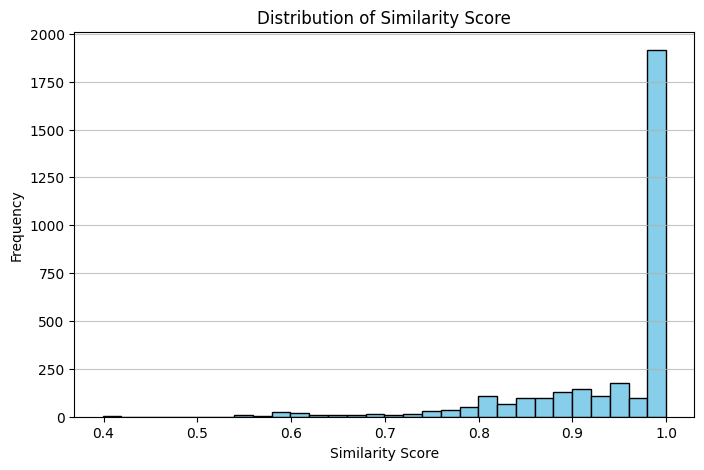

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df['Similarity Score'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Similarity Score')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:


def main():
    df = pd.read_csv("output.csv")
    output_rows = []
    for i, row in df.iterrows():
        if i == 3:break
        prompt = build_rag_prompt(row["Original Diagnosis"], row["ICD-10 Code"], row["ICD-10 Description"], row["Similarity Score"])
        if row["Similarity Score"] < SIMILARITY_THRESHOLD:
            try:
                explanation = generate_explanation_gemini(prompt)
                model_used = "Gemini"
            except Exception as e:
                explanation = f"Error: {e}"
                model_used = "Gemini (Error)"
            time.sleep(0.5)  # To avoid Gemini rate limits
        else:
            explanation = generate_explanation_local(prompt)
            model_used = "Local LLM"
        output_row = row.to_dict()
        output_row["RAG Explanation"] = explanation
        output_row["Model Used"] = model_used
        output_rows.append(output_row)
        if (i+1) % 50 == 0:
            print(f"Processed {i+1} rows...")
    output_df = pd.DataFrame(output_rows)
    output_df.to_csv("rag_output.csv", index=False)
    print("Saved rag_output.csv")

if __name__ == "__main__":
    main()


Saved rag_output.csv


In [ ]:


def main():
    df = pd.read_csv("output.csv")
    output_rows = []
    for i, row in df.iterrows():
        if i == 3:break
        prompt = build_rag_prompt(row["Original Diagnosis"], row["ICD-10 Code"], row["ICD-10 Description"], row["Similarity Score"])
        if row["Similarity Score"] < SIMILARITY_THRESHOLD:
            try:
                explanation = generate_explanation_gemini(prompt)
                model_used = "Gemini"
            except Exception as e:
                explanation = f"Error: {e}"
                model_used = "Gemini (Error)"
            time.sleep(0.5)  # To avoid Gemini rate limits
        else:
            explanation = generate_explanation_local(prompt)
            model_used = "Local LLM"
        output_row = row.to_dict()
        output_row["RAG Explanation"] = explanation
        output_row["Model Used"] = model_used
        output_rows.append(output_row)
        if (i+1) % 50 == 0:
            print(f"Processed {i+1} rows...")
    output_df = pd.DataFrame(output_rows)
    output_df.to_csv("rag_output.csv", index=False)
    print("Saved rag_output.csv")

if __name__ == "__main__":
    main()


Saved rag_output.csv


In [99]:
df['Original Diagnosis'].head(10)

0    Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled
1                                                                                     Pure hypercholesterolemia
2                                                                           Unspecified acquired hypothyroidism
3                                                                                          Tobacco use disorder
4                                                                Personal history of malignant melanoma of skin
5                                                                                      Hypotension, unspecified
6                                                               Acute appendicitis with generalized peritonitis
7                                                                            Long-term (current) use of aspirin
8                                                                     Acquired absence of organ, genital

In [ ]:


def main():
    df = pd.read_csv("output.csv")
    output_rows = []
    for i, row in df.iterrows():
        if i == 3:break
        prompt = build_rag_prompt(row["Original Diagnosis"], row["ICD-10 Code"], row["ICD-10 Description"], row["Similarity Score"])
        if row["Similarity Score"] < SIMILARITY_THRESHOLD:
            try:
                explanation = generate_explanation_gemini(prompt)
                model_used = "Gemini"
            except Exception as e:
                explanation = f"Error: {e}"
                model_used = "Gemini (Error)"
            time.sleep(0.5)  # To avoid Gemini rate limits
        else:
            explanation = generate_explanation_local(prompt)
            model_used = "Local LLM"
        output_row = row.to_dict()
        output_row["RAG Explanation"] = explanation
        output_row["Model Used"] = model_used
        output_rows.append(output_row)
        if (i+1) % 50 == 0:
            print(f"Processed {i+1} rows...")
    output_df = pd.DataFrame(output_rows)
    output_df.to_csv("rag_output.csv", index=False)
    print("Saved rag_output.csv")

if __name__ == "__main__":
    main()


Saved rag_output.csv


In [179]:
df = pd.read_csv('flot\output_part_7_rag.csv')
df
df['RAG Explanation'].unique()

array(['The ICD-10 code R6881 accurately describes early satiety in terms of duration and severity. It indicates a condition that begins shortly after eating and persists for several days to weeks, often associated with gastrointestinal issues such as bloating, gas, and diarrhea. <END>',
       'The ICD-10 code G893 accurately describes acute pain associated with neoplasms, particularly those that may be chronic in nature. This code effectively categorizes the condition as one of the types of pain related to cancer, making it suitable for both acute and chronic cases. <END>',
       'The ICD-10 code T85591D correctly identifies esophageal reflux disease as a complication that occurs after an esophageal anti-reflux device has been used. It captures the mechanism of esophageal reflux without additional information about the underlying condition. <END>',
       'The ICD-10 code I748 accurately describes an embolic event involving multiple arteries, which is consistent with the clinical pr

In [ ]:
df = pd.read_csv('rag_output.csv')
df
df['RAG Explanation'].unique()

array(['The answer should be concise and to the point.',
       'The answer should be concise and to the point. Pure hypercholesterolemia is a condition where the blood cholesterol levels are elevated, but there is no specific cause identified in the medical record.',
       'The answer should be a single sentence.',
       'The answer should be a single word. appropriate match.',
       'The answer should be a single word.'], dtype=object)

In [155]:
k = pd.read_csv('output.csv')
k['Row_ID'].value_counts()

Row_ID
92    160
10    126
73    117
24    111
58    109
     ... 
47      5
26      4
32      4
41      4
17      3
Name: count, Length: 100, dtype: int64

In [ ]:
k = pd.read_csv('output.csv')
print("COLUMNS:", k.columns)  # Add this after loading k

# Inside your loop, before using row["Original Diagnosis"]:
for i, (index, row) in enumerate(tqdm(k.iterrows(), total=len(k))):
    print("ROW TYPE:", type(row))
    print("ROW CONTENT:", row)
    break  # Just print the first row and stop for now

COLUMNS: Index(['Row_ID', 'Original Diagnosis', 'ICD-10 Code', 'ICD-10 Description',
       'Similarity Score'],
      dtype='object')


  0%|          | 0/3171 [00:00<?, ?it/s]

ROW TYPE: <class 'pandas.core.series.Series'>
ROW CONTENT: Row_ID                                                                                                                         0
Original Diagnosis    Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled
ICD-10 Code                                                                                                                E1169
ICD-10 Description                                                    Type 2 diabetes mellitus with other specified complication
Similarity Score                                                                                                            0.88
Name: 0, dtype: object


In [181]:
import pandas as pd
import glob
import os

# Path to your flot directory
flot_dir = "flot"

# Find all *_rag.csv files (ignore partials)
all_files = sorted(glob.glob(os.path.join(flot_dir, "output_part_*_rag.csv")))

# Read and concatenate all chunk files
df = pd.concat([pd.read_csv(f) for f in all_files], ignore_index=True)

# Get the first 100 unique Row_IDs (patients)
first_100_ids = df['Row_ID'].drop_duplicates().sort_values().head(100).tolist()

# Filter to only those Row_IDs
filtered_df = df[df['Row_ID'].isin(first_100_ids)]

# Group by Row_ID and aggregate as lists
grouped = filtered_df.groupby('Row_ID').agg({
    'Original Diagnosis': list,
    'ICD-10 Code': list,
    'ICD-10 Description': list,
    'Similarity Score': list,
    'RAG Explanation': list
}).reset_index()

# Optionally, convert lists to stringified lists for CSV readability
for col in ['Original Diagnosis', 'ICD-10 Code', 'ICD-10 Description', 'Similarity Score', 'RAG Explanation']:
    grouped[col] = grouped[col].apply(lambda x: str(x))

# Save to a single CSV
grouped.to_csv("patients_grouped_first_100.csv", index=False)
print("Saved patients_grouped_first_100.csv with", len(grouped), "patients.")

Saved patients_grouped_first_100.csv with 100 patients.


In [182]:
grouped

Row_ID  \
0        0   
1        1   
2        2   
3        3   
4        4   
..     ...   
95      95   
96      96   
97      97   
98      98   
99      99   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [ ]:
df = pd.read_csv('flot\output_part_7_rag.csv')
df
df['RAG Explanation'].unique()

array(['The ICD-10 code R6881 accurately describes early satiety in terms of duration and severity. It indicates a condition that begins shortly after eating and persists for several days to weeks, often associated with gastrointestinal issues such as bloating, gas, and diarrhea. <END>',
       'The ICD-10 code G893 accurately describes acute pain associated with neoplasms, particularly those that may be chronic in nature. This code effectively categorizes the condition as one of the types of pain related to cancer, making it suitable for both acute and chronic cases. <END>',
       'The ICD-10 code T85591D correctly identifies esophageal reflux disease as a complication that occurs after an esophageal anti-reflux device has been used. It captures the mechanism of esophageal reflux without additional information about the underlying condition. <END>',
       'The ICD-10 code I748 accurately describes an embolic event involving multiple arteries, which is consistent with the clinical pr